In [11]:
from jetutils.jet_finding import JetFindingExperiment
from jetutils.definitions import DATADIR, compute, xarray_to_polars, get_region, FIGURES
from jetutils.plots import Clusterplot, COLORS
from jetutils.data import DataHandler, open_dataset, compute_anomalies_pl
from jetutils.clustering import Experiment
from jetutils.anyspell import mask_from_spells_pl, get_persistent_spell_times_from_som
import colormaps

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from pathlib import Path
import datetime

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
basepath = Path("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical")
ds = open_dataset(basepath.joinpath("ds.zarr"))
ds["time"] = ds.indexes["time"].to_datetimeindex(time_unit="ns")
da_s = compute(ds["s"], progress_flag=True)
dh = DataHandler.from_basepath_and_da(basepath.joinpath("results"), da_s)
exp = Experiment(dh)

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


In [3]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year"), pl.col("member")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "1d"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "1d"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "1d"),
    ).drop("year", "start", "end")
    return [seasons[["member", season]].explode(season).sort("member", season) for season in ["spring", "summer", "autumn"]]

In [4]:
centers_kmeans, labels_kmeans = exp.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
members = summer["member"].unique().sort().to_numpy()
index = summer.to_pandas().set_index(["member", "summer"]).index
summer_da = dh.da.stack({"megatime": ["member", "time"]}).sel(megatime=index).transpose("megatime", ...)
dh_summer = DataHandler.from_basepath_and_da(exp.path.parent, summer_da, save_da=False)
exp_summer = Experiment(dh_summer)
net_summer, centers_summer, labels_summer = exp_summer.som_cluster(4, 4, 200, sigma=1.5, sigmaN=1e-5, train_kwargs=dict(num_epochs=20), init="pca")

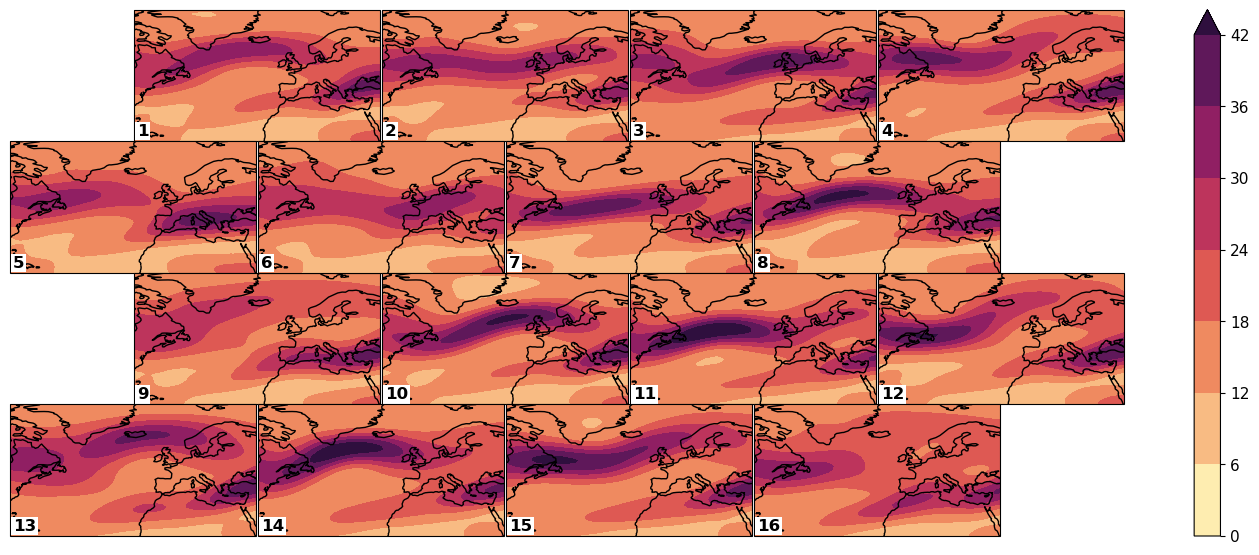

In [5]:
clu = Clusterplot(4, 4, get_region(dh.da), honeycomb=True, numbering=True)
_ = clu.add_contourf(centers_summer, cmap=colormaps.matter, levels=7)

# Intransivity

In [6]:
centers_kmeans, labels_kmeans = exp.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
members = spring["member"].unique().sort().to_numpy()
index = spring.to_pandas().set_index(["member", "spring"]).index
spring_da = dh.da.stack({"megatime": ["member", "time"]}).sel(megatime=index).transpose("megatime", ...)
dh_spring = DataHandler.from_basepath_and_da(exp.path.parent, spring_da, save_da=False)
exp_spring = Experiment(dh_spring)
net_spring, centers_spring, labels_spring = exp_spring.som_cluster(3, 2, 200, sigma=0.9, sigmaN=1e-5, train_kwargs=dict(num_epochs=20), PBC=False, init="pca")

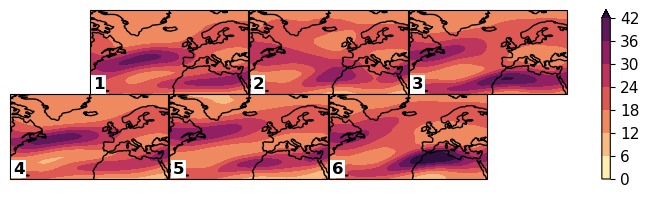

In [7]:
clu = Clusterplot(net_spring.y, net_spring.x, get_region(dh.da), honeycomb=True, numbering=True)
_ = clu.add_contourf(centers_spring, cmap=colormaps.matter, levels=7)

In [8]:
from scipy.stats import ttest_ind
def to_distrib(
    labels_df: pl.DataFrame, expected_nlabels: int | None = None
) -> pl.DataFrame:
    distrib = (
        labels_df.group_by(["member", "year", "labels"])
        .len()
        .sort(["member", "year", "labels"])
    )
    index_ = distrib[["member", "year"]].unique(maintain_order=True)
    if expected_nlabels is None:
        labels_ = distrib[["labels"]].unique().sort("labels")
    else:
        labels_ = pl.Series("labels", np.arange(expected_nlabels)).to_frame()
    index_ = index_.join(labels_, how="cross")
    distrib = index_.join(
        distrib, on=["member", "year", "labels"], how="left"
    ).fill_null(0)
    return distrib

rng1 = np.random.default_rng()
rng2 = np.random.default_rng()
coords = net_summer.neighborhoods.coordinates
labels_spring = xarray_to_polars(labels_spring).with_columns(year=pl.col("time").dt.year())
labels_summer = xarray_to_polars(labels_summer).with_columns(year=pl.col("time").dt.year())
winners_spring = labels_spring["labels"].value_counts(sort=True)
start_of_summer = labels_summer.group_by(["member", "year"], maintain_order=True).first().with_columns(pl.col("time").dt.ordinal_day().alias("first_summer_day")).drop("time")
winners_summer = start_of_summer["labels"].value_counts(sort=True)
ny = labels_summer["year"].n_unique()
ne = labels_summer["member"].n_unique()

spring_pops = labels_spring["labels"].value_counts().sort("labels")
spring_pops = spring_pops.with_columns(pl.col("count") / ny / ne)
spring_pops_values = np.zeros(net_spring.n_nodes)
spring_pops_values[spring_pops["labels"]] = spring_pops["count"]

summer_pops = labels_summer["labels"].value_counts().sort("labels")
summer_pops = summer_pops.with_columns(pl.col("count") / ny / ne)
summer_pops_values = np.zeros(net_summer.n_nodes)
summer_pops_values[summer_pops["labels"]] = summer_pops["count"]

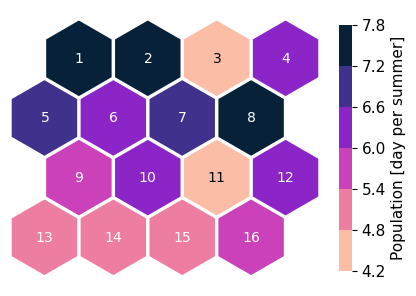

In [9]:
fig, ax = net_summer.plot_on_map(
    summer_pops_values,
    smooth_sigma=0,
    show=True,
    cmap=colormaps.bubblegum_r,
    discretify=True,
    draw_cbar=True,
    numbering=True,
    cbar_kwargs={"label": "Population [day per summer]"}
)

## where is spring

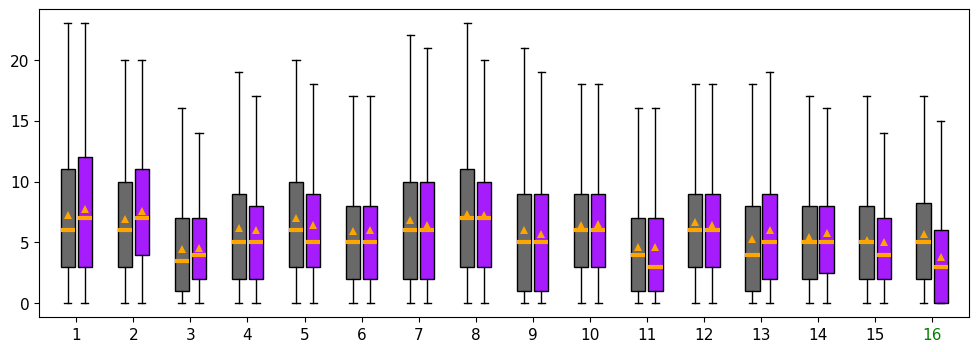

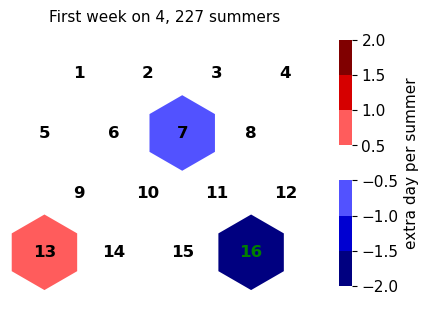

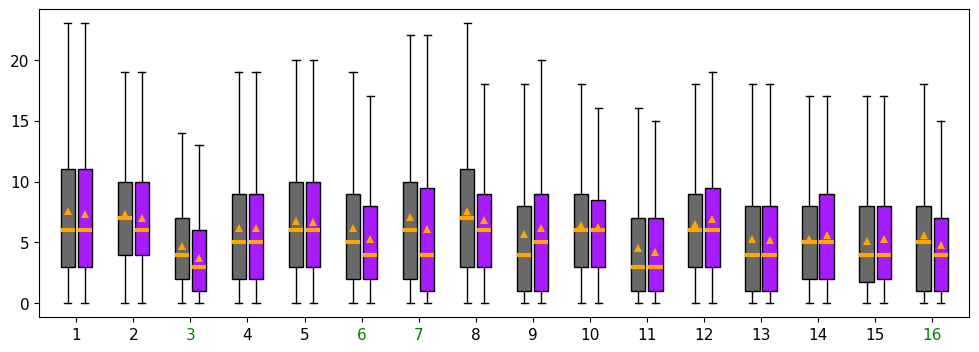

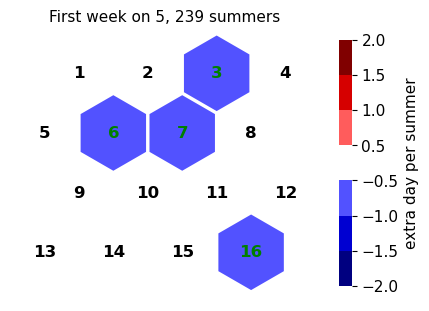

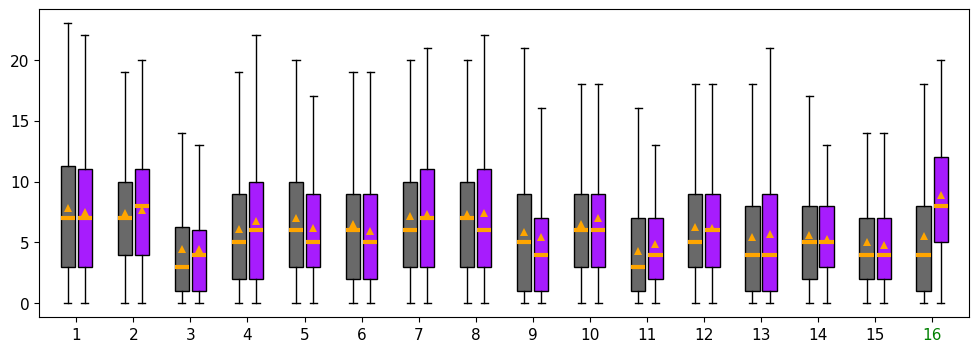

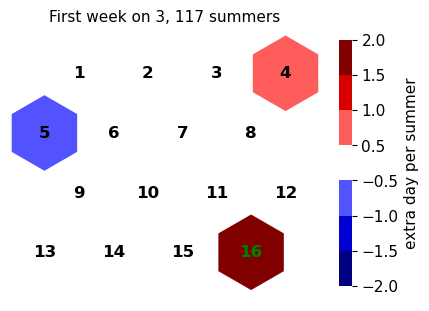

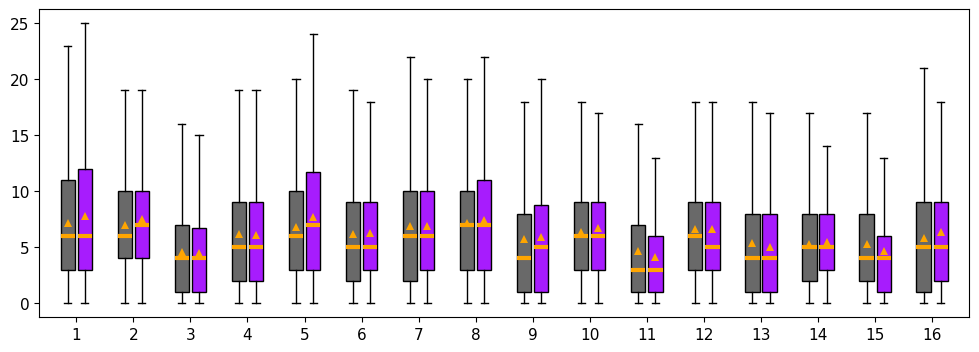

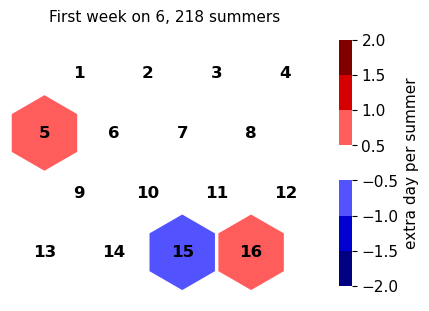

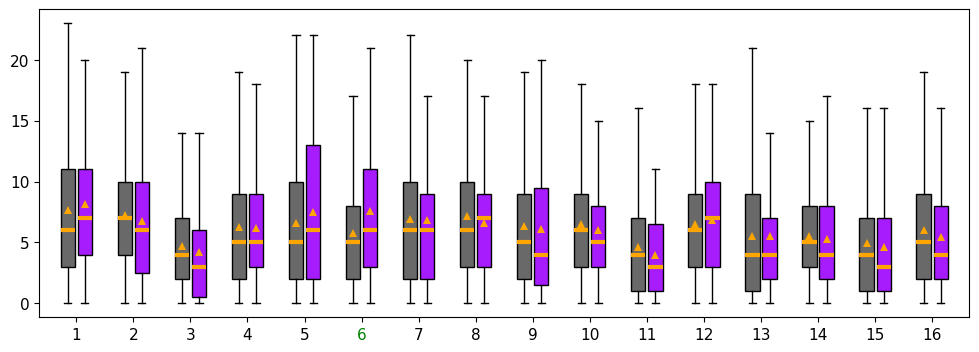

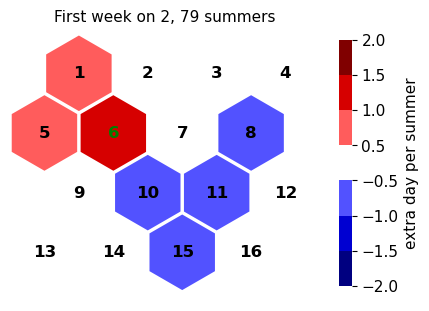

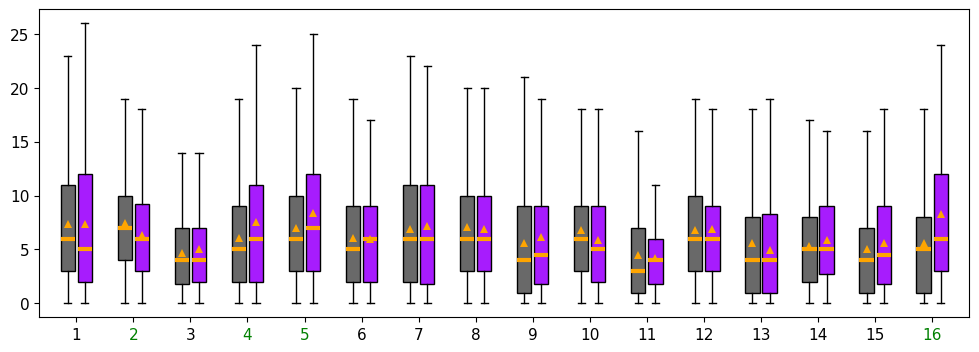

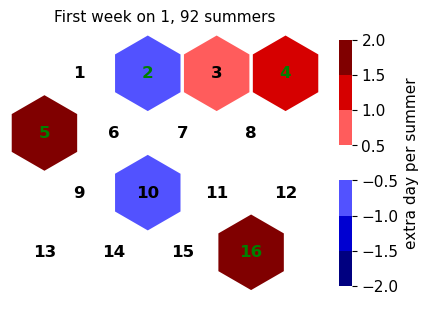

In [12]:
for i in range(net_spring.n_nodes):
    june_winner = winners_spring[i, "labels"]
    filter_ = labels_spring.group_by(
        ["member", "year"], maintain_order=True
    ).agg(proportion=(pl.col("labels") == june_winner).sum() / pl.col("labels").len())
    filter_ = filter_.filter(pl.col("proportion") > 0.5)
    when_ = filter_.group_by("year").len().sort("year").with_row_index()
    which_members_ = filter_.group_by("member").len().sort("member").with_row_index()
    ny_ = filter_["year"].n_unique()
    ne_ = filter_["member"].n_unique()
    filtered_summer = filter_.join(labels_summer, on=["member", "year"])

    main_distrib = to_distrib(labels_summer, expected_nlabels=net_summer.n_nodes)
    to_test_distrib = to_distrib(filtered_summer, expected_nlabels=net_summer.n_nodes)
    years_ = labels_summer["year"].unique()
    labels_ = labels_summer["labels"].unique()
    members_ = labels_summer["member"].unique()

    n_draws = 1000
    # draw_from_years = np.repeat(when_["index"], when_["len"] + 10)
    draw_from_years = np.arange(len(years_))
    drawn_years = rng1.choice(draw_from_years, n_draws)
    # draw_from_members = which_members_["index"].to_numpy()
    draw_from_members = np.arange(len(members_))
    drawn_members = rng2.choice(draw_from_members, n_draws)
    indices = (drawn_members * len(years_) + drawn_years) * len(labels_)
    indices = indices[:, None] + labels_.to_numpy()[None, :]
    drawn_distribs = main_distrib["len"].to_numpy()[indices]
    to_test_distrib = (
        to_test_distrib["len"].to_numpy().reshape(filter_.shape[0], len(labels_))
    )
    fig, ax = plt.subplots(figsize=(12, 4))
    markercolor = "orange"
    bp1 = ax.boxplot(
        drawn_distribs,
        positions=np.arange(1, net_summer.n_nodes + 1) - 0.15,
        widths=0.25,
        showfliers=False,
        showmeans=True,
        patch_artist=True,
        medianprops={"color": markercolor, "linewidth": 3},
        meanprops={"markerfacecolor": markercolor, "markeredgewidth": 0},
    )
    for box in bp1["boxes"]:
        box.set_facecolor("dimgrey")
    bp2 = ax.boxplot(
        to_test_distrib,
        positions=np.arange(1, net_summer.n_nodes + 1) + 0.15,
        widths=0.25,
        showfliers=False,
        showmeans=True,
        patch_artist=True,
        medianprops={"color": markercolor, "linewidth": 3},
        meanprops={"markerfacecolor": markercolor, "markeredgewidth": 0},
    )
    for box in bp2["boxes"]:
        box.set_facecolor(COLORS[0])
    ticks = ax.set_xticks(np.arange(1, net_summer.n_nodes + 1), labels=np.arange(1, net_summer.n_nodes + 1))
    ticklabels = ax.get_xticklabels()
    for i in range(net_summer.n_nodes):
        ttest_res = ttest_ind(
            drawn_distribs[:, i], to_test_distrib[:, i], equal_var=False
        )
        if ttest_res.pvalue < 0.05:
            ticklabels[i].set_color(color="green")

    filtered_summer = filtered_summer["labels"].value_counts().sort("labels")
    filtered_summer = filtered_summer.with_columns(pl.col("count") / filter_.shape[0])
    levels = np.arange(-2.0, 2.2, 0.5)
    levels = np.delete(levels, len(levels) // 2)
    cmap = colormaps.BlWhRe
    norm = BoundaryNorm(levels, cmap.N)
    filtered_summer_values = np.zeros(net_summer.n_nodes)
    filtered_summer_values[filtered_summer["labels"]] = filtered_summer["count"]
    plt.savefig(f"{FIGURES}/som_intransivity/distribs_spring_at_{june_winner}")
    fig, ax = net_summer.plot_on_map(
        filtered_summer_values - summer_pops_values,
        smooth_sigma=0,
        show=True,
        cmap=cmap,
        norm=norm,
        draw_cbar=True,
        cbar_label="extra day per summer",
    )
    for i, c in enumerate(coords):
        signif = (
            ttest_ind(
                drawn_distribs[:, i], to_test_distrib[:, i], equal_var=False
            ).pvalue
            < 0.05
        )
        color = "green" if signif else "black"
        ax.text(
            *c,
            str(i + 1),
            color=color,
            ha="center",
            va="center",
            fontsize=12,
            fontweight="demi",
            usetex=False,
        )
    ax.set_title(f"First week on {june_winner + 1}, {filter_.shape[0]} summers")
    plt.savefig(f"{FIGURES}/som_intransivity/map_spring_at_{june_winner}")
    # plt.savefig("/Users/bandelol/Documents/code_local/GM-20240424/figs/map")

## when does summer start

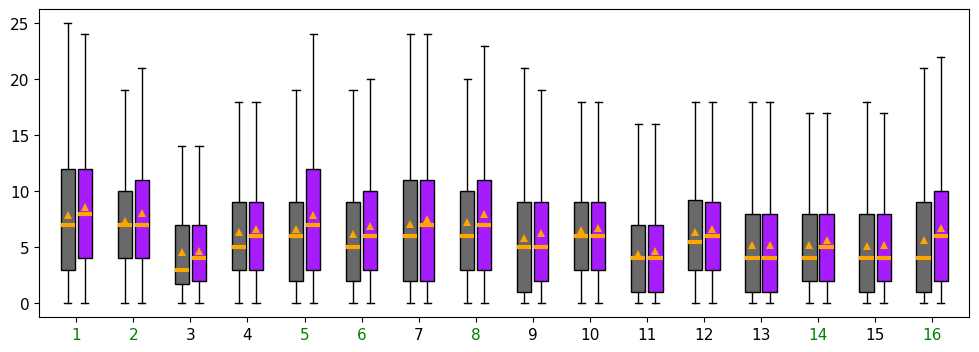

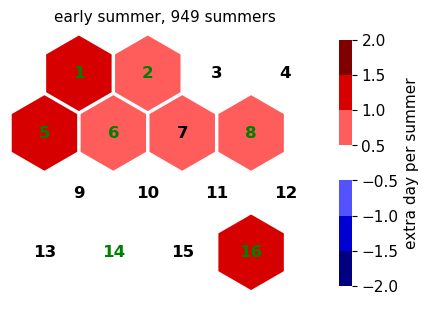

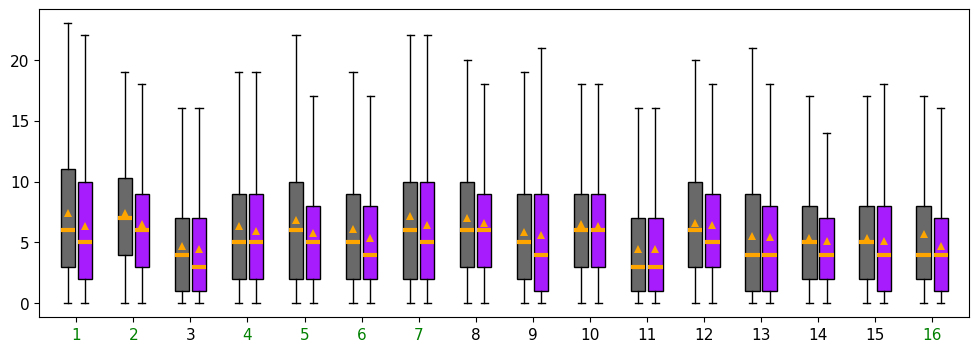

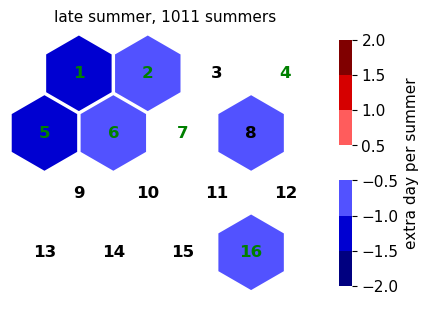

In [13]:
mean_fdos = start_of_summer["first_summer_day"].mean()
filter_below = start_of_summer.filter(pl.col("first_summer_day") < mean_fdos).drop("labels")
filter_above = start_of_summer.filter(pl.col("first_summer_day") > mean_fdos).drop("labels")
for filter_, name_ in zip([filter_below, filter_above], ["early", "late"]):
    when_ = filter_.group_by("year").len().sort("year").with_row_index()
    which_members_ = filter_.group_by("member").len().sort("member").with_row_index()
    ny_ = filter_["year"].n_unique()
    ne_ = filter_["member"].n_unique()
    filtered_summer = filter_.join(labels_summer, on=["member", "year"])

    main_distrib = to_distrib(labels_summer, expected_nlabels=net_summer.n_nodes)
    to_test_distrib = to_distrib(filtered_summer, expected_nlabels=net_summer.n_nodes)
    years_ = labels_summer["year"].unique()
    labels_ = labels_summer["labels"].unique()
    members_ = labels_summer["member"].unique()

    n_draws = 1000
    # draw_from_years = np.repeat(when_["index"], when_["len"] + 10)
    draw_from_years = np.arange(len(years_))
    drawn_years = rng1.choice(draw_from_years, n_draws)
    # draw_from_members = which_members_["index"].to_numpy()
    draw_from_members = np.arange(len(members_))
    drawn_members = rng2.choice(draw_from_members, n_draws)
    indices = (drawn_members * len(years_) + drawn_years) * len(labels_)
    indices = indices[:, None] + labels_.to_numpy()[None, :]
    drawn_distribs = main_distrib["len"].to_numpy()[indices]
    to_test_distrib = (
        to_test_distrib["len"].to_numpy().reshape(filter_.shape[0], len(labels_))
    )
    fig, ax = plt.subplots(figsize=(12, 4))
    markercolor = "orange"
    bp1 = ax.boxplot(
        drawn_distribs,
        positions=np.arange(1, net_summer.n_nodes + 1) - 0.15,
        widths=0.25,
        showfliers=False,
        showmeans=True,
        patch_artist=True,
        medianprops={"color": markercolor, "linewidth": 3},
        meanprops={"markerfacecolor": markercolor, "markeredgewidth": 0},
    )
    for box in bp1["boxes"]:
        box.set_facecolor("dimgrey")
    bp2 = ax.boxplot(
        to_test_distrib,
        positions=np.arange(1, net_summer.n_nodes + 1) + 0.15,
        widths=0.25,
        showfliers=False,
        showmeans=True,
        patch_artist=True,
        medianprops={"color": markercolor, "linewidth": 3},
        meanprops={"markerfacecolor": markercolor, "markeredgewidth": 0},
    )
    for box in bp2["boxes"]:
        box.set_facecolor(COLORS[0])
    ticks = ax.set_xticks(np.arange(1, net_summer.n_nodes + 1), labels=np.arange(1, net_summer.n_nodes + 1))
    ticklabels = ax.get_xticklabels()
    for i in range(net_summer.n_nodes):
        ttest_res = ttest_ind(
            drawn_distribs[:, i], to_test_distrib[:, i], equal_var=False
        )
        if ttest_res.pvalue < 0.05:
            ticklabels[i].set_color(color="green")

    filtered_summer = filtered_summer["labels"].value_counts().sort("labels")
    filtered_summer = filtered_summer.with_columns(pl.col("count") / filter_.shape[0])
    levels = np.arange(-2.0, 2.2, 0.5)
    levels = np.delete(levels, len(levels) // 2)
    cmap = colormaps.BlWhRe
    norm = BoundaryNorm(levels, cmap.N)
    filtered_summer_values = np.zeros(net_summer.n_nodes)
    filtered_summer_values[filtered_summer["labels"]] = filtered_summer["count"]
    plt.savefig(f"{FIGURES}/som_intransivity/distribs_{name_}_summer")
    fig, ax = net_summer.plot_on_map(
        filtered_summer_values - summer_pops_values,
        smooth_sigma=0,
        show=True,
        cmap=cmap,
        norm=norm,
        draw_cbar=True,
        cbar_label="extra day per summer",
    )
    for i, c in enumerate(coords):
        signif = (
            ttest_ind(
                drawn_distribs[:, i], to_test_distrib[:, i], equal_var=False
            ).pvalue
            < 0.05
        )
        color = "green" if signif else "black"
        ax.text(
            *c,
            str(i + 1),
            color=color,
            ha="center",
            va="center",
            fontsize=12,
            fontweight="demi",
            usetex=False,
        )
    ax.set_title(f"{name_} summer, {filter_.shape[0]} summers")
    plt.savefig(f"{FIGURES}/som_intransivity/map_{name_}_summer")

## where does summer start

In [ ]:
for i in range(6):
    summer_winner = winners_summer[i, "labels"]
    filter_ = start_of_summer.filter(pl.col("labels") == summer_winner).drop("labels")
    when_ = filter_.group_by("year").len().sort("year").with_row_index()
    which_members_ = filter_.group_by("member").len().sort("member").with_row_index()
    ny_ = filter_["year"].n_unique()
    ne_ = filter_["member"].n_unique()
    filtered_summer = filter_.join(labels_summer, on=["member", "year"])

    main_distrib = to_distrib(labels_summer, expected_nlabels=net_summer.n_nodes)
    to_test_distrib = to_distrib(filtered_summer, expected_nlabels=net_summer.n_nodes)
    years_ = labels_summer["year"].unique()
    labels_ = labels_summer["labels"].unique()
    members_ = labels_summer["member"].unique()

    n_draws = 1000
    # draw_from_years = np.repeat(when_["index"], when_["len"] + 10)
    draw_from_years = np.arange(len(years_))
    drawn_years = rng1.choice(draw_from_years, n_draws)
    # draw_from_members = which_members_["index"].to_numpy()
    draw_from_members = np.arange(len(members_))
    drawn_members = rng2.choice(draw_from_members, n_draws)
    indices = (drawn_members * len(years_) + drawn_years) * len(labels_)
    indices = indices[:, None] + labels_.to_numpy()[None, :]
    drawn_distribs = main_distrib["len"].to_numpy()[indices]
    to_test_distrib = (
        to_test_distrib["len"].to_numpy().reshape(filter_.shape[0], len(labels_))
    )
    fig, ax = plt.subplots(figsize=(12, 4))
    markercolor = "orange"
    bp1 = ax.boxplot(
        drawn_distribs,
        positions=np.arange(1, net_summer.n_nodes + 1) - 0.15,
        widths=0.25,
        showfliers=False,
        showmeans=True,
        patch_artist=True,
        medianprops={"color": markercolor, "linewidth": 3},
        meanprops={"markerfacecolor": markercolor, "markeredgewidth": 0},
    )
    for box in bp1["boxes"]:
        box.set_facecolor("dimgrey")
    bp2 = ax.boxplot(
        to_test_distrib,
        positions=np.arange(1, net_summer.n_nodes + 1) + 0.15,
        widths=0.25,
        showfliers=False,
        showmeans=True,
        patch_artist=True,
        medianprops={"color": markercolor, "linewidth": 3},
        meanprops={"markerfacecolor": markercolor, "markeredgewidth": 0},
    )
    for box in bp2["boxes"]:
        box.set_facecolor(COLORS[0])
    ticks = ax.set_xticks(np.arange(1, net_summer.n_nodes + 1), labels=np.arange(1, net_summer.n_nodes + 1))
    ticklabels = ax.get_xticklabels()
    for i in range(net_summer.n_nodes):
        ttest_res = ttest_ind(
            drawn_distribs[:, i], to_test_distrib[:, i], equal_var=False
        )
        if ttest_res.pvalue < 0.05:
            ticklabels[i].set_color(color="green")

    filtered_summer = filtered_summer["labels"].value_counts().sort("labels")
    filtered_summer = filtered_summer.with_columns(pl.col("count") / filter_.shape[0])
    levels = np.arange(-2.0, 2.2, 0.5)
    levels = np.delete(levels, len(levels) // 2)
    cmap = colormaps.BlWhRe
    norm = BoundaryNorm(levels, cmap.N)
    filtered_summer_values = np.zeros(net_summer.n_nodes)
    filtered_summer_values[filtered_summer["labels"]] = filtered_summer["count"]
    plt.savefig(f"{FIGURES}/som_intransivity/distribs_summer_on_{summer_winner}")
    fig, ax = net_summer.plot_on_map(
        filtered_summer_values - summer_pops_values,
        smooth_sigma=0,
        show=True,
        cmap=cmap,
        norm=norm,
        draw_cbar=True,
        cbar_label="extra day per summer",
    )
    for i, c in enumerate(coords):
        signif = (
            ttest_ind(
                drawn_distribs[:, i], to_test_distrib[:, i], equal_var=False
            ).pvalue
            < 0.05
        )
        color = "green" if signif else "black"
        ax.text(
            *c,
            str(i + 1),
            color=color,
            ha="center",
            va="center",
            fontsize=12,
            fontweight="demi",
            usetex=False,
        )
    ax.set_title(f"First day on {summer_winner + 1}, {filter_.shape[0]} summers")
    plt.savefig(f"{FIGURES}/som_intransivity/map_summer_on_{summer_winner}")

# kmeans populations

In [ ]:
weekly = labels_kmeans.group_by(pl.col("time").dt.week().alias("week")).agg(pl.col("labels").unique(), pl.col("labels").unique_counts().alias("count")).explode("labels", "count").sort("week", "labels")
unique_weeks = weekly["week"].unique().to_frame()
unique_labels = weekly["labels"].unique().to_frame()
index = unique_weeks.join(unique_labels, how="cross")
weekly = index.join(weekly, on=index.columns, how="left").fill_null(0)

(0.0, 14268.800000000001)

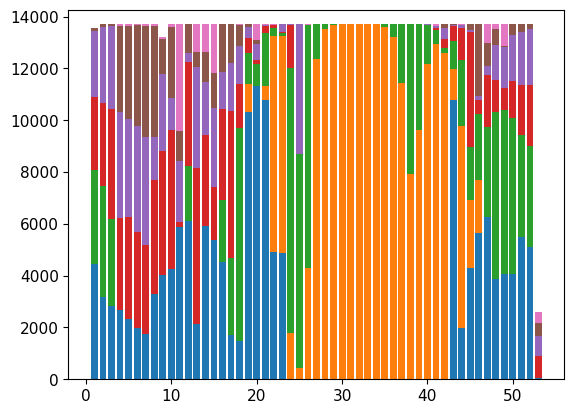

In [ ]:
bottom = np.zeros(len(unique_weeks))
x = unique_weeks["week"].to_numpy()
fig, ax = plt.subplots()
for lab in unique_labels["labels"].to_numpy():
    y = weekly.filter(pl.col("labels") == lab)["count"]
    plt.bar(x, y, bottom=bottom)
    bottom = bottom + y
ax.set_ylim(0, bottom.max() * 1.04)

In [ ]:
monthly = xarray_to_polars(labels_kmeans).group_by(pl.col("time").dt.month().alias("month")).agg(pl.col("labels").unique(), pl.col("labels").unique_counts().alias("count")).explode("labels", "count").sort("month", "labels")
unique_weeks = monthly["month"].unique().to_frame()
unique_labels = monthly["labels"].unique().to_frame()
index = unique_weeks.join(unique_labels, how="cross")
monthly = index.join(monthly, on=index.columns, how="left").fill_null(0)

In [ ]:
bottom = np.zeros(12)
x = np.arange(12)
fig, ax = plt.subplots()
for lab in unique_labels["labels"].to_numpy():
    y = monthly.filter(pl.col("labels") == lab)["count"]
    plt.bar(x, y, bottom=bottom)
    bottom = bottom + y
ax.set_ylim(0, bottom.max() * 1.04)